1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


import warnings
warnings.filterwarnings('ignore')

2. Loading the dataset

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayantikalaskar","key":"9c46cbc3dc0f3d53e9eef348359a288e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d harshghadiya/kidneystone

Dataset URL: https://www.kaggle.com/datasets/harshghadiya/kidneystone
License(s): other
  0% 0.00/1.89k [00:00<?, ?B/s]
100% 1.89k/1.89k [00:00<00:00, 4.72MB/s]


In [5]:
!unzip kidneystone.zip

Archive:  kidneystone.zip
  inflating: kidney-stone-dataset.csv  


In [9]:
df = pd.read_csv("/content/kidney-stone-dataset.csv")

# drop the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
df.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


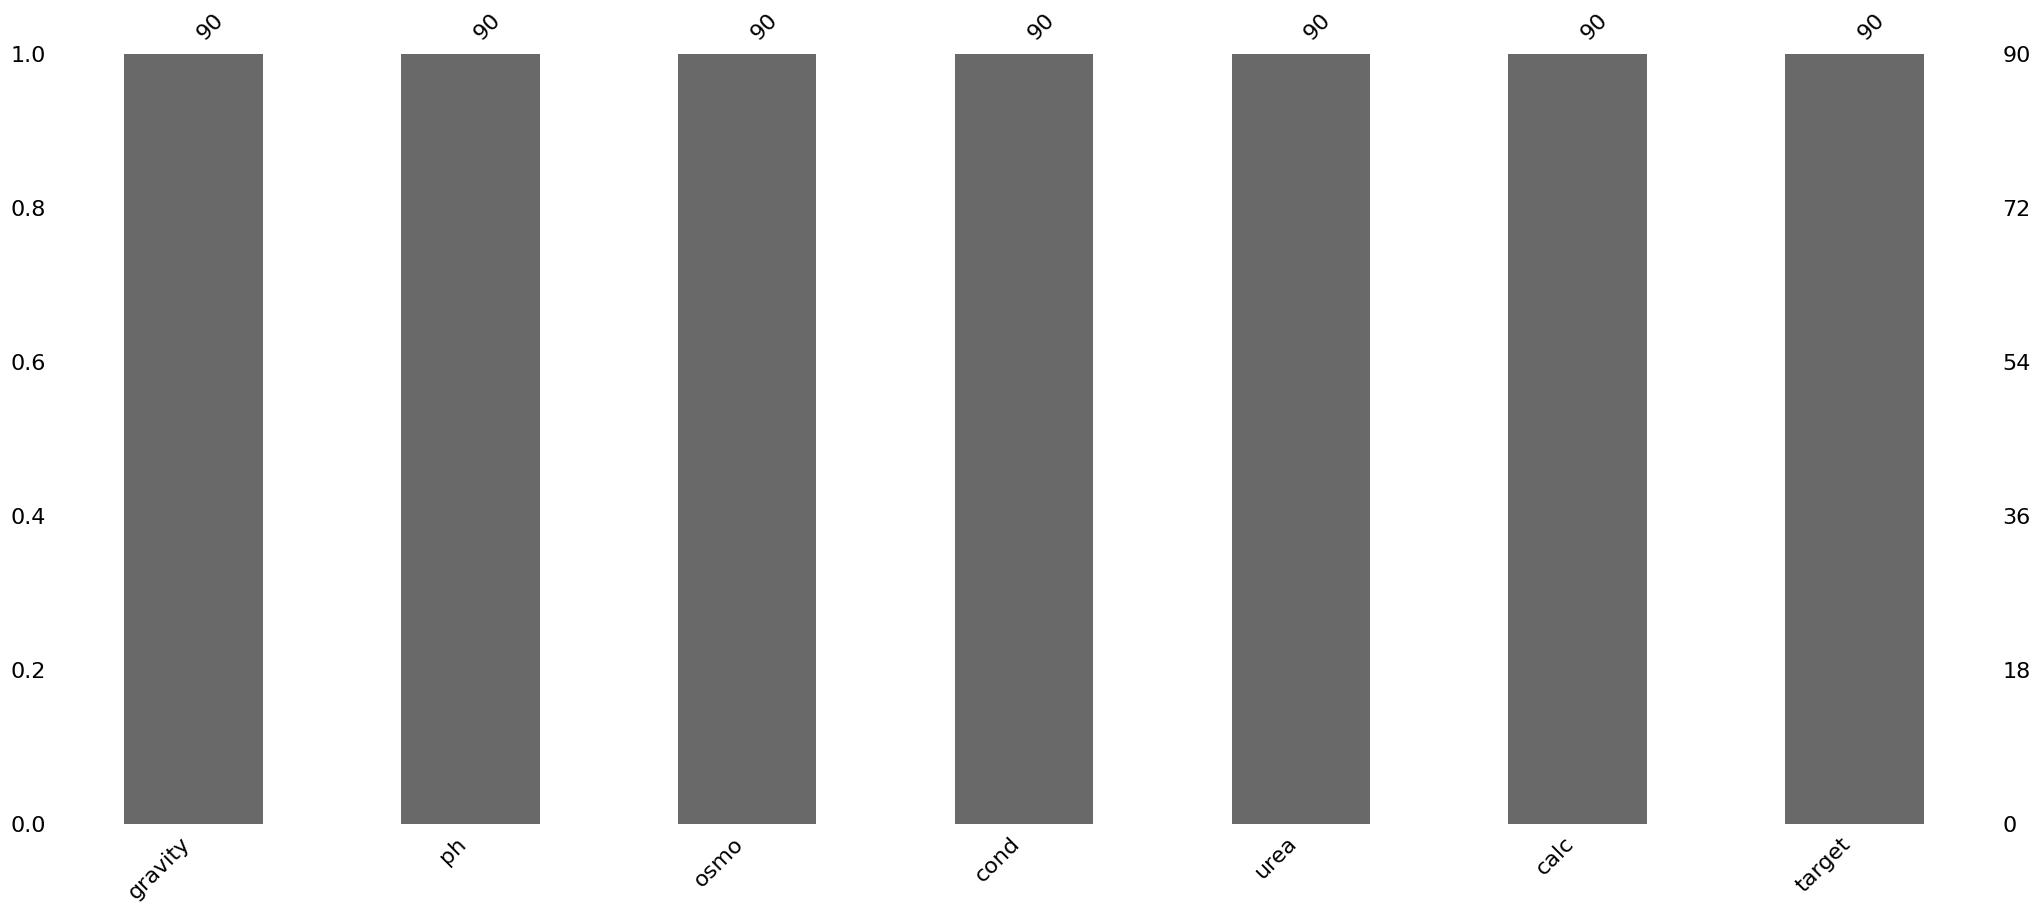

In [11]:
msno.bar(df);

In [12]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,gravity,float64,0,0.000000
1,ph,float64,0,0.000000
2,osmo,int64,0,0.000000
3,cond,float64,0,0.000000
4,urea,int64,0,0.000000
5,calc,float64,0,0.000000
6,target,int64,0,0.000000


In [13]:
print(f"Summary Of The Dataset with numerical columns :")
df.describe().style.set_properties(**{"background-color": "#121d6b","color":"#e9c46a","border": "1.5px solid black"})

Summary Of The Dataset with numerical columns :


,gravity,ph,osmo,cond,urea,calc,target
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,1.017952,6.036651,602.333333,20.621687,258.200000,4.017788,0.500000
std,0.006780,0.711801,238.459805,7.654448,135.381127,3.016273,0.502801
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,1.012258,5.536520,411.500000,14.150000,148.250000,1.412500,0.000000
50%,1.018000,5.936247,572.000000,21.177172,231.500000,3.230000,0.500000
75%,1.023000,6.490000,778.000000,26.075000,366.250000,5.965127,1.000000
max,1.034000,7.940000,1236.000000,38.000000,620.000000,13.000000,1.000000


In [14]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gravity: 41 distinct values
ph: 80 distinct values
osmo: 85 distinct values
cond: 76 distinct values
urea: 82 distinct values
calc: 86 distinct values
target: 2 distinct values


In [15]:
df.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

In [16]:
df.duplicated().sum()

0

3. Exploration Data Analysis

In [17]:
df1 = df.copy()

In [18]:
df1_numericals = df1.select_dtypes(['int64','float64'])
numericals = [i for i in df1_numericals.columns]
print('numericals: ', numericals)

numericals:  ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']


Univariate

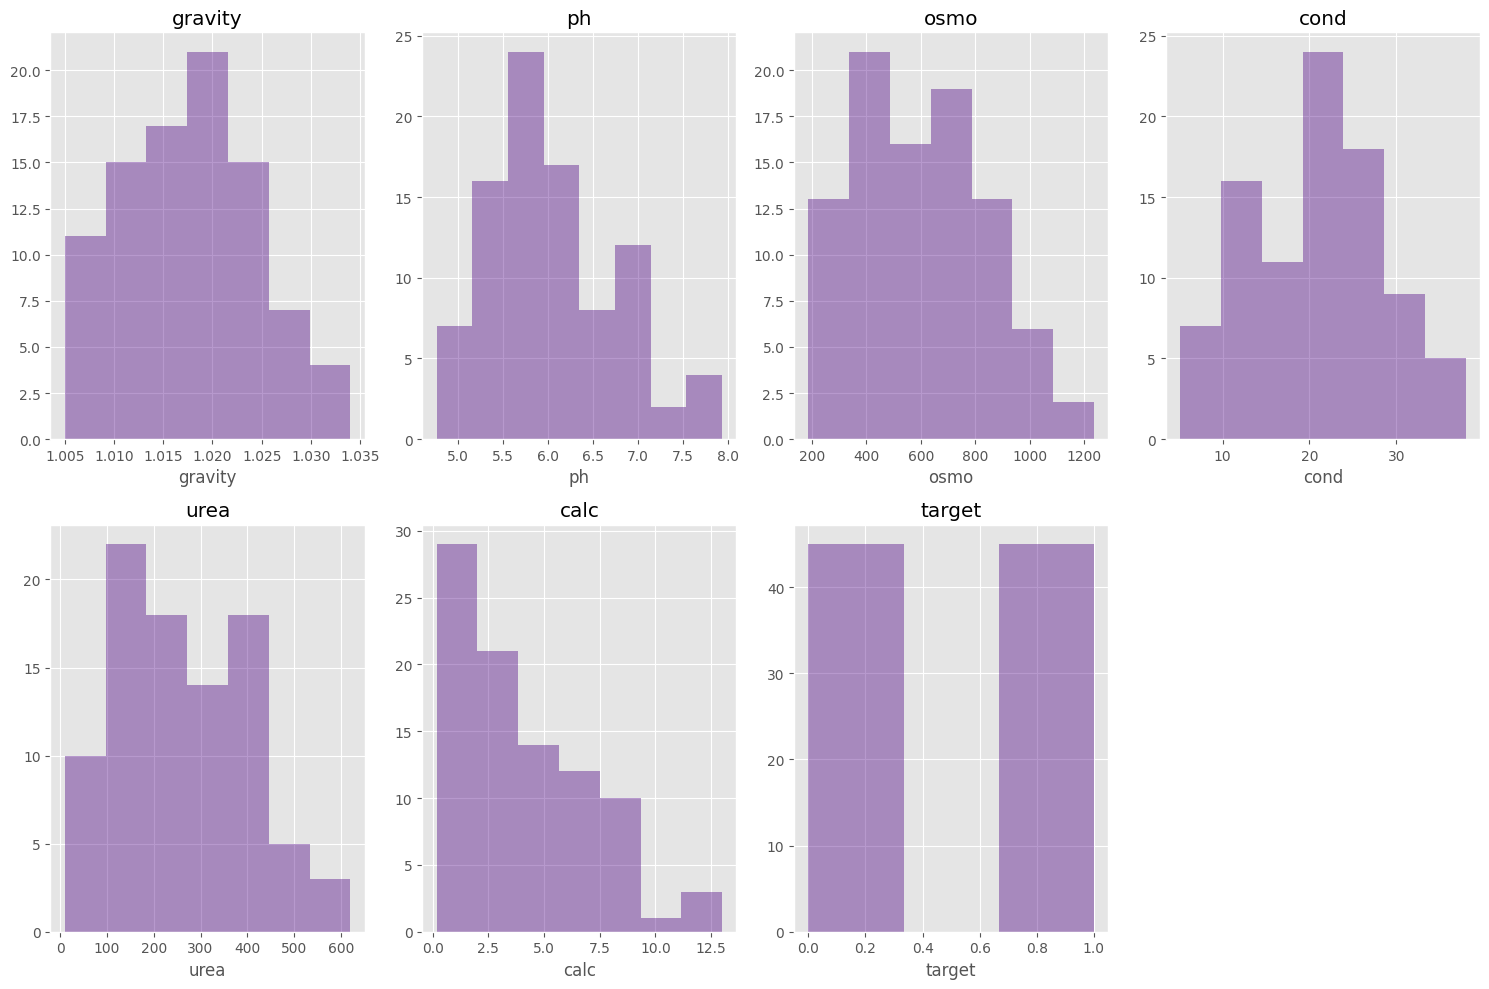

In [19]:
plt.style.use('ggplot')

numeric_columns = df1_numericals.columns


plt.figure(figsize=(15, 10))

for i, variable in enumerate(numeric_columns):
    plt.subplot(2, 4, i + 1)
    sns.distplot(df1_numericals[variable], kde=False, color='indigo')
    plt.tight_layout()
    plt.title(variable)

Bivariate

<Figure size 1200x600 with 0 Axes>

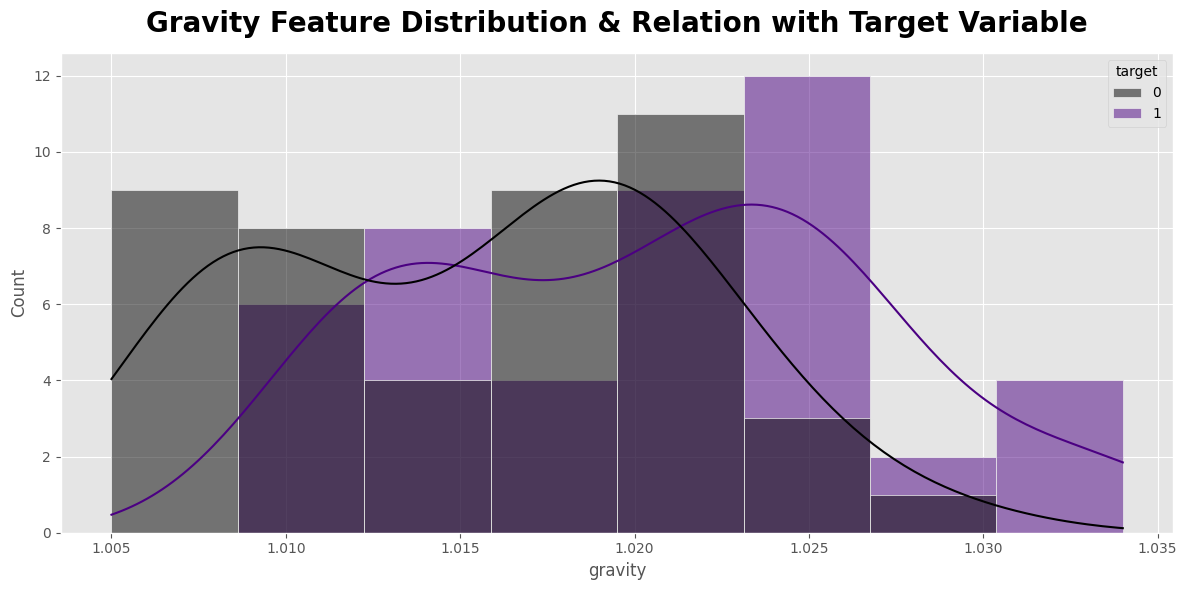

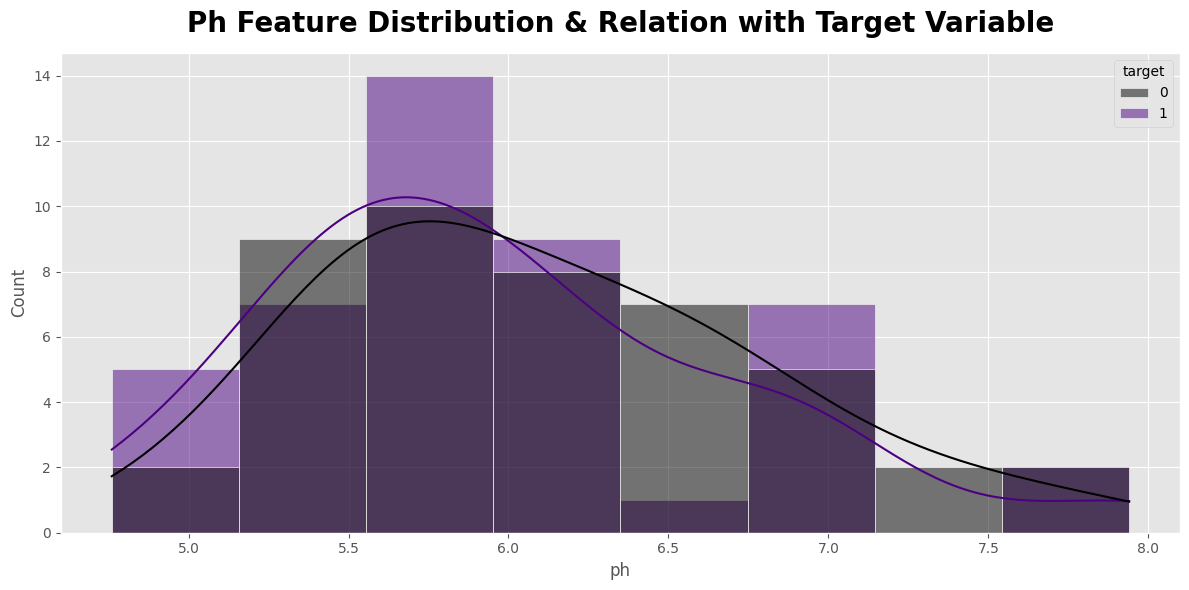

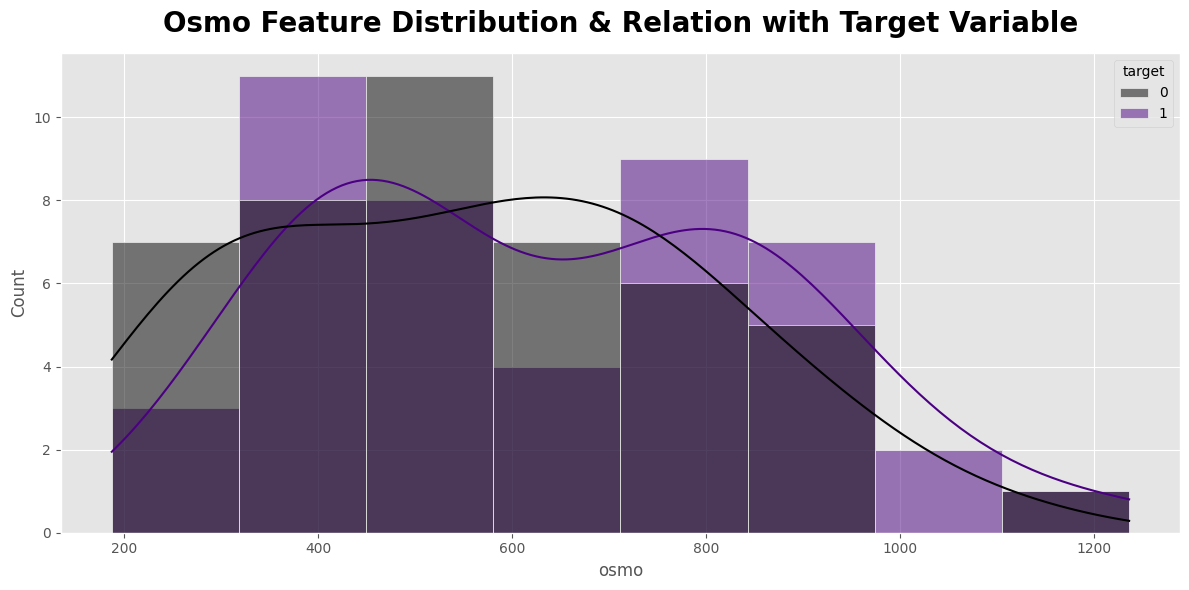

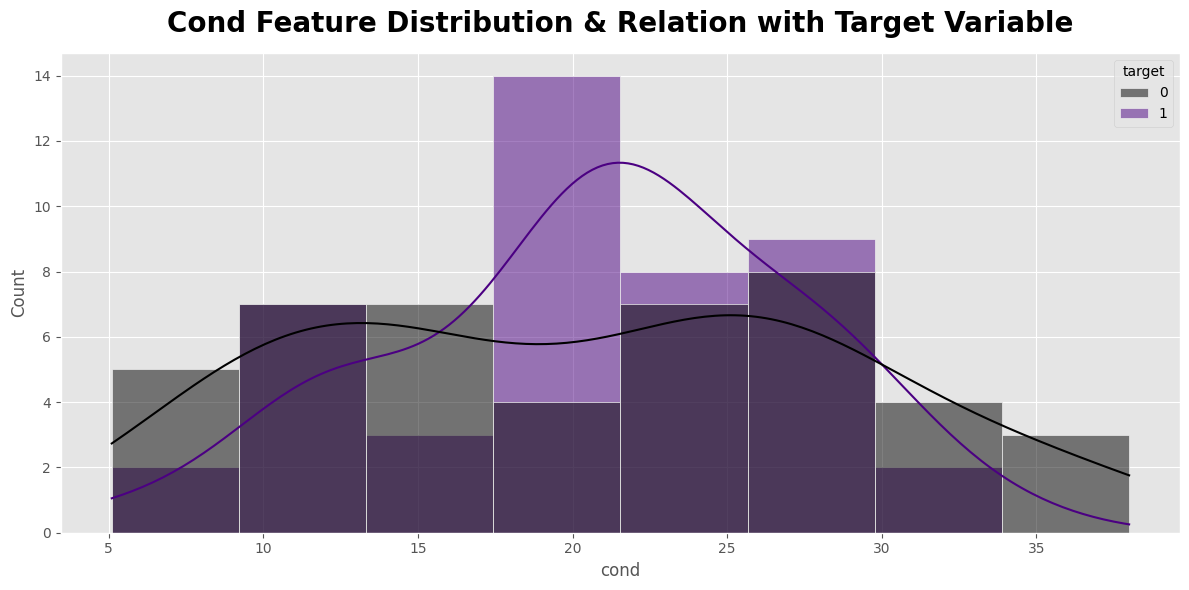

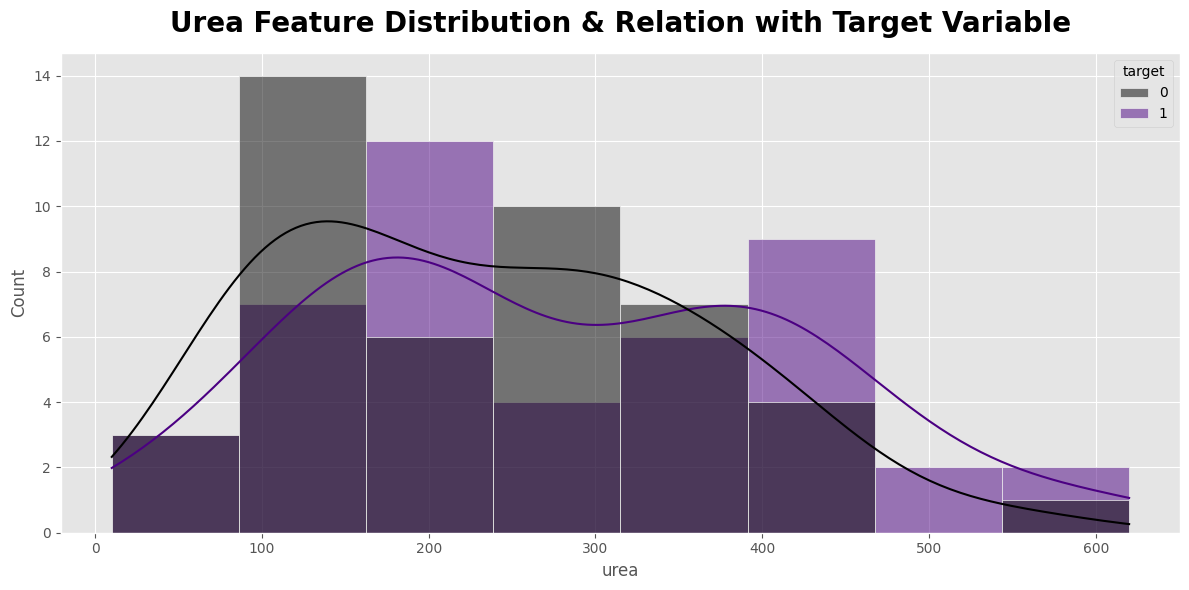

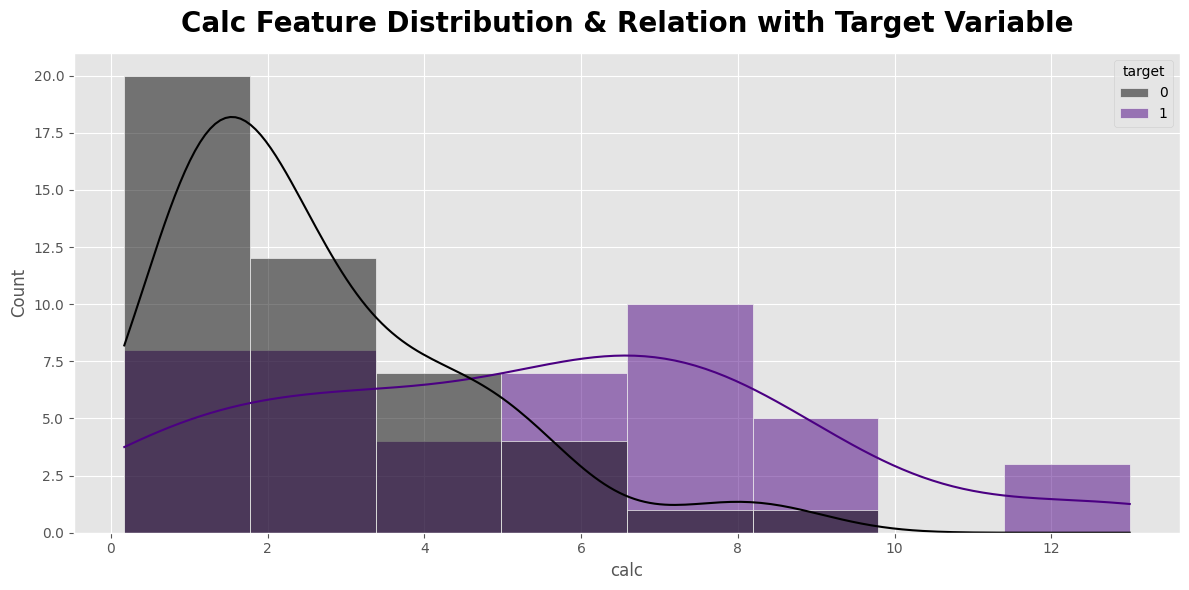

In [20]:
columns_to_plot = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

plt.figure(figsize=(12, 6))

for column in columns_to_plot:
    plt.figure(figsize=(12,6))
    sns.histplot(x=df1[column], hue=df1["target"], kde=True, palette=["black", "indigo"])
    plt.title(f"{column.capitalize()} Feature Distribution & Relation with Target Variable", fontweight="black", size=20, pad=15)
    plt.tight_layout()
    plt.show()

Multivariate

In [21]:
df1.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

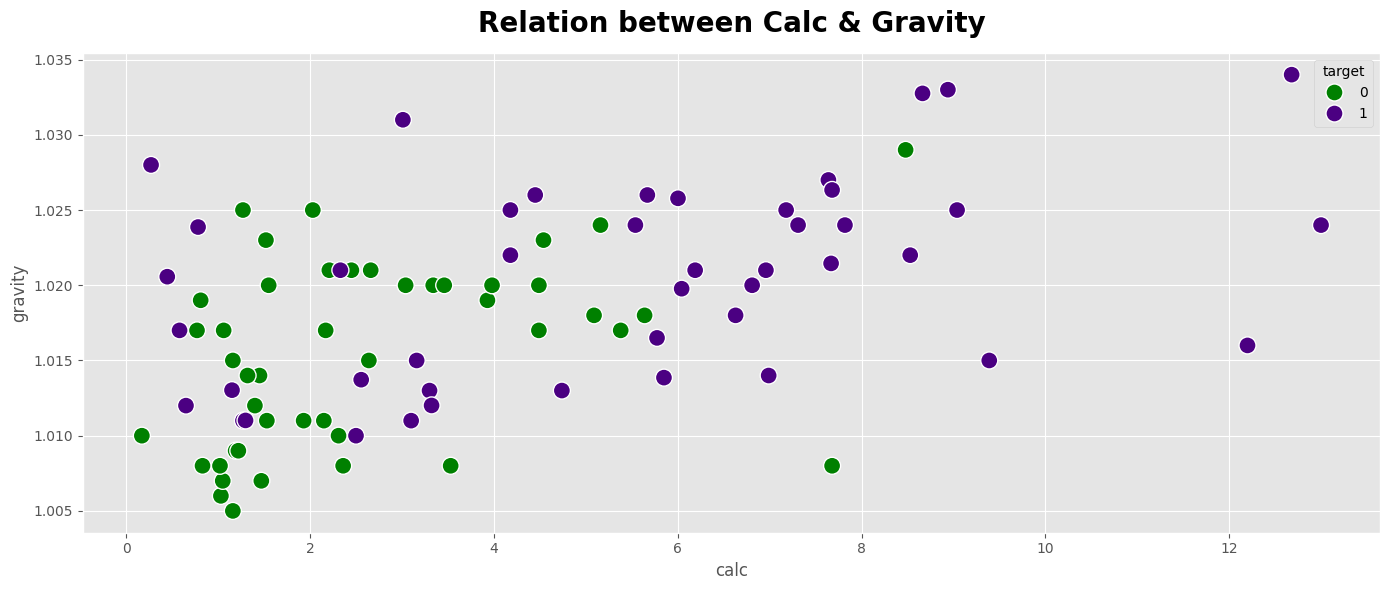

In [22]:
plt.figure(figsize=(14,6))
sns.scatterplot(x="calc",y="gravity",data=df1,hue="target", markers=["o", "s"], s=150,palette=["green","indigo"])
plt.title("Relation between Calc & Gravity",fontweight="black",size=20,pad=15)
plt.tight_layout()
plt.show()

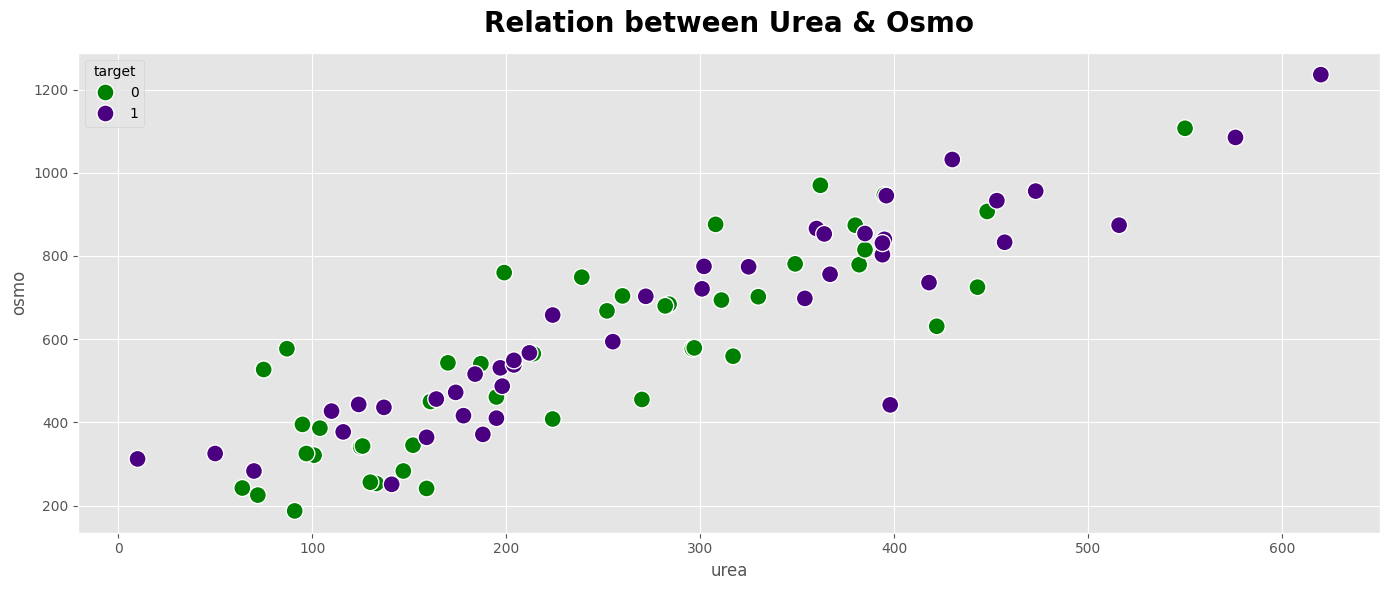

In [23]:
plt.figure(figsize=(14,6))
sns.scatterplot(x="urea",y="osmo",data=df1,hue="target", markers=["o", "s"], s=150,palette=["green","indigo"])
plt.title("Relation between Urea & Osmo",fontweight="black",size=20,pad=15)
plt.tight_layout()
plt.show()

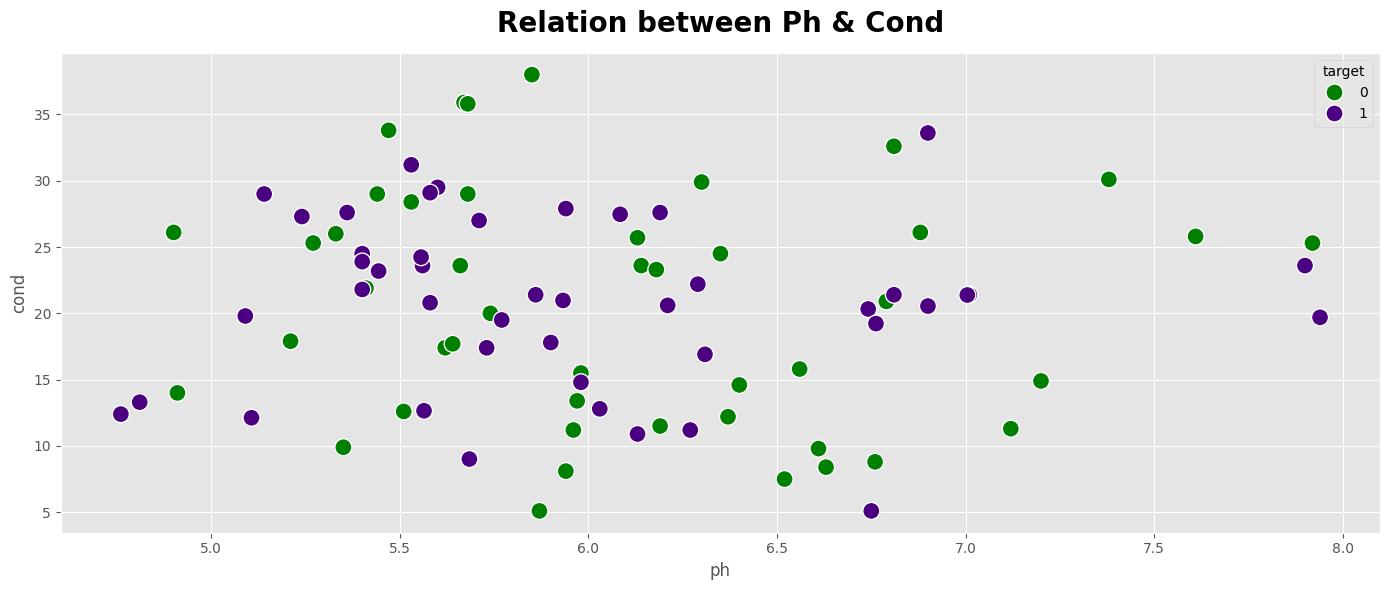

In [24]:
plt.figure(figsize=(14,6))
sns.scatterplot(x="ph",y="cond",data=df1,hue="target", markers=["o", "s"], s=150,palette=["green","indigo"])
plt.title("Relation between Ph & Cond",fontweight="black",size=20,pad=15)
plt.tight_layout()
plt.show()

Correlation Matrix

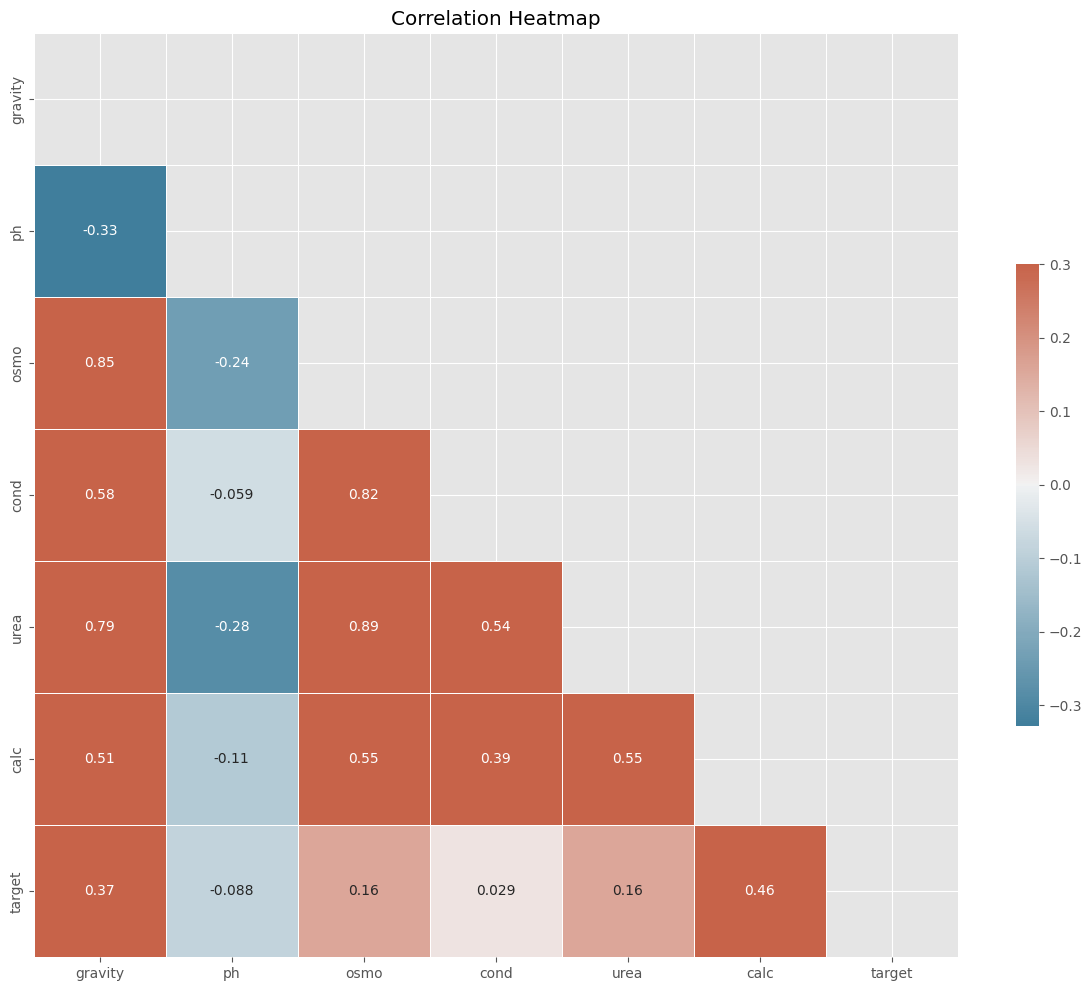

In [25]:
corr = df1.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Heatmap')
plt.show()

4. Prepocesing

Imbalace Data

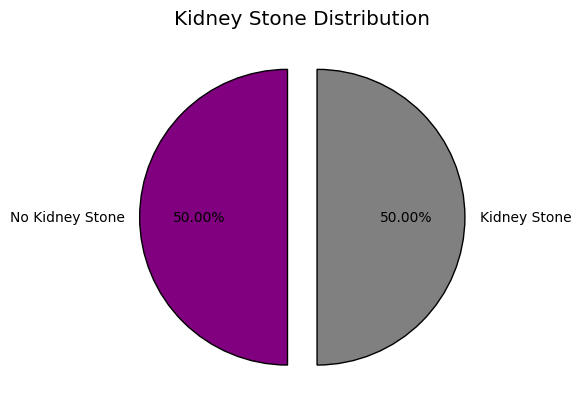

In [26]:
true_count = df1['target'].sum()
false_count = len(df1) - true_count
total_count = len(df1)
kidney_stone_percentage = (true_count / total_count) * 100
no_kidney_stone_percentage = (false_count / total_count) * 100

pie_values = [no_kidney_stone_percentage, kidney_stone_percentage]
colors = ['purple', 'grey']

# Pie chart
plt.pie(pie_values, labels=['No Kidney Stone', 'Kidney Stone'],
        autopct='%1.2f%%',
        startangle=90,
        explode=(0.1, 0.1),
        colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Kidney Stone Distribution')

plt.show()

Outliers

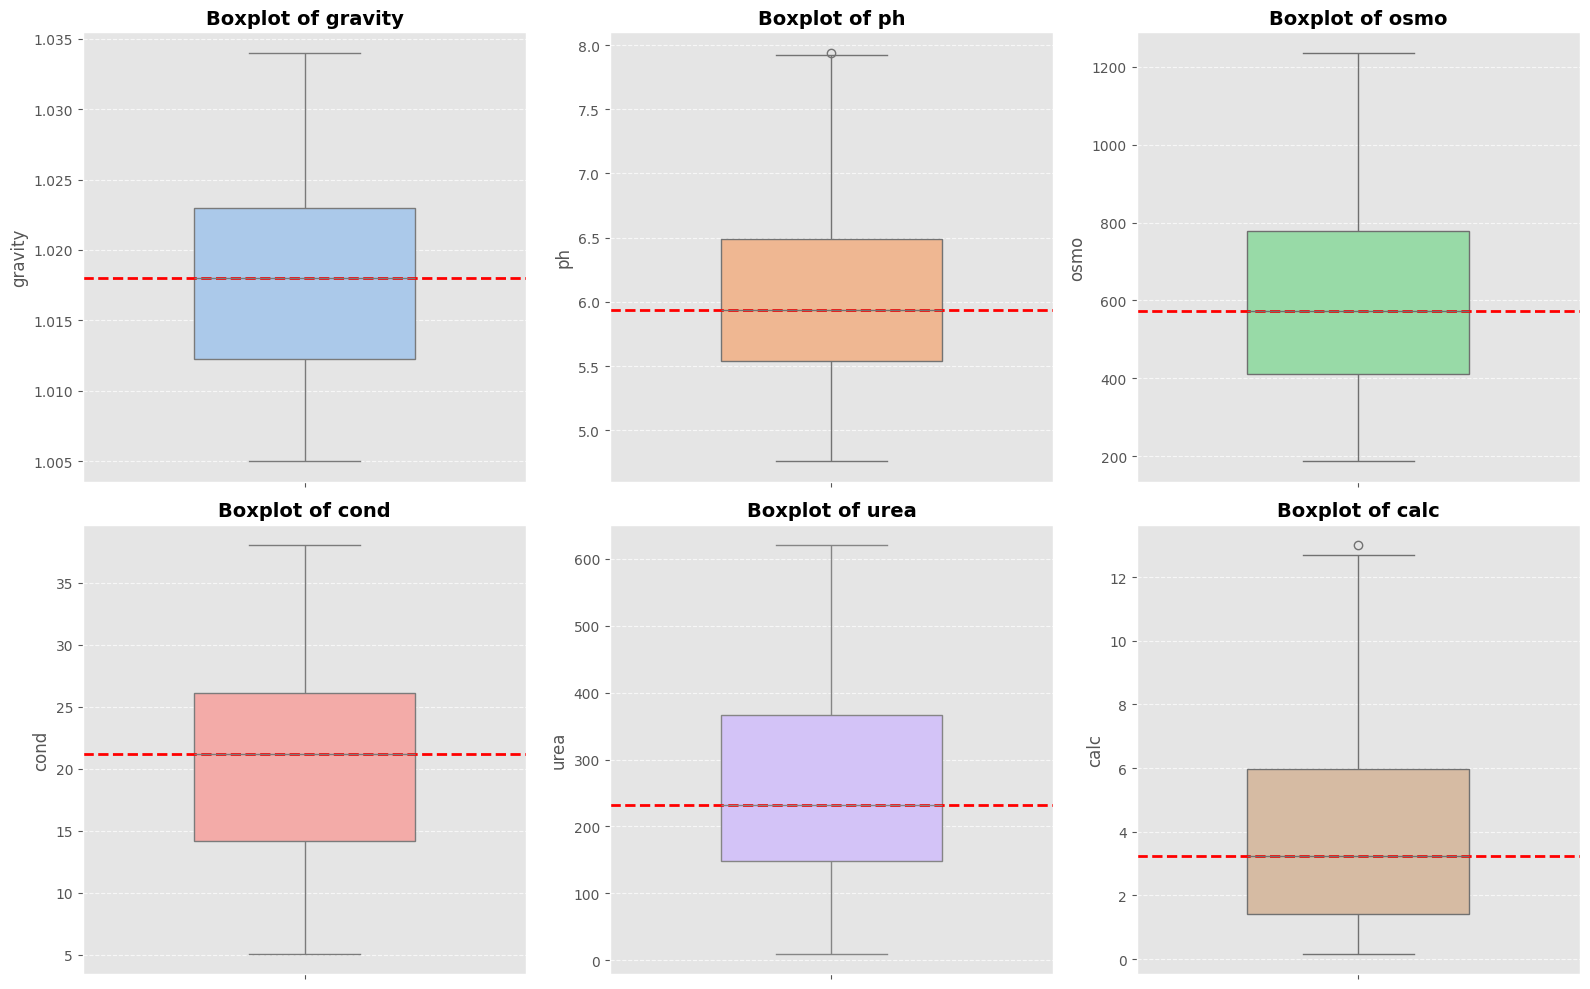

In [27]:
numerical_cols = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

palette = sns.color_palette('pastel', n_colors=len(numerical_cols))

plt.figure(figsize=(16, 10))
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df1[column], color=palette[i-1], width=0.5)
    plt.axhline(y=df1[column].median(), color='red', linestyle='--', linewidth=2)
    plt.title(f'Boxplot of {column}', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Normalize Data

In [28]:
features_to_scale_robust = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']


robust_scaler = RobustScaler()

df1[features_to_scale_robust] = robust_scaler.fit_transform(df1[features_to_scale_robust])

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

for feature in features_to_scale_robust:
    num_outliers = count_outliers(df1[feature])
    print(f'Number of outliers in {feature}: {num_outliers}')

Number of outliers in gravity: 0
Number of outliers in ph: 1
Number of outliers in osmo: 0
Number of outliers in cond: 0
Number of outliers in urea: 0
Number of outliers in calc: 1


In [29]:
scaler = StandardScaler()

df1[features_to_scale_robust] = scaler.fit_transform(df1[features_to_scale_robust])

In [30]:
df2  = df1.copy()

In [31]:
X = df2.drop(['target'], axis=1)
y = df2['target']
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [32]:
X_resampled.describe().T.style.background_gradient(axis=0, cmap='Set3')

,count,mean,std,min,25%,50%,75%,max
gravity,90.000000,0.446615,0.233806,0.000000,0.250281,0.448276,0.620690,1.000000
ph,90.000000,0.401463,0.223837,0.000000,0.244189,0.369889,0.544025,1.000000
osmo,90.000000,0.395933,0.227321,0.000000,0.214013,0.367016,0.563394,1.000000
cond,90.000000,0.471784,0.232658,0.000000,0.275076,0.488668,0.637538,1.000000
urea,90.000000,0.406885,0.221936,0.000000,0.226639,0.363115,0.584016,1.000000
calc,90.000000,0.299906,0.235095,0.000000,0.096843,0.238504,0.451686,1.000000


Principal Component Analysis (PCA)

In [33]:
decom = PCA(svd_solver='auto')
X_pca = decom.fit_transform(X_scaled)

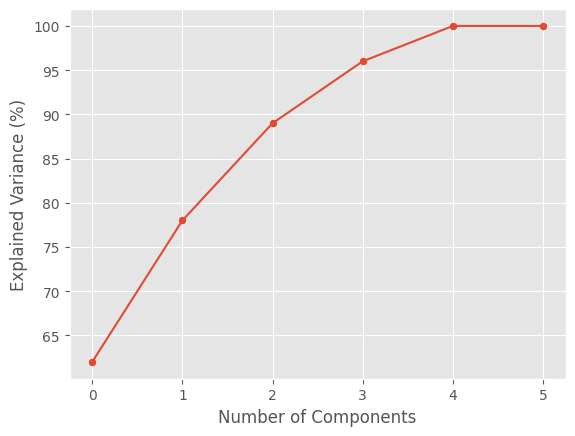

In [34]:
x_var = np.cumsum(np.round(decom.explained_variance_ratio_, 2)) * 100
sns.lineplot(y=x_var, x=np.arange(0, len(x_var)))
sns.scatterplot(y=x_var, x=np.arange(0, len(x_var)))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (%)')
plt.show()

Split Data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings ('ignore')

5.Modeling

SVC

In [37]:
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

svc = SVC()

randomized_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_params = randomized_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_svc_model = randomized_search.best_estimator_
svc_predicted = best_svc_model.predict(X_test)

svc_acc_score = accuracy_score(y_test, svc_predicted)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)

print("\nConfusion Matrix:")
print(svc_conf_matrix)
print("\nAccuracy of Support Vector Classifier:", svc_acc_score * 100, '\n')
print("Classification Report:")
print(classification_report(y_test, svc_predicted))

Best Hyperparameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 10}

Confusion Matrix:
[[7 5]
 [1 5]]

Accuracy of Support Vector Classifier: 66.66666666666666 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.50      0.83      0.62         6

    accuracy                           0.67        18
   macro avg       0.69      0.71      0.66        18
weighted avg       0.75      0.67      0.68        18



Extra Trees Classifier

In [38]:
param_dist_et = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

et = ExtraTreesClassifier()

randomized_search_et = RandomizedSearchCV(
    et,
    param_distributions=param_dist_et,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_et.fit(X_train, y_train)

best_params_et = randomized_search_et.best_params_
print(f"Best Hyperparameters for Extra Trees Classifier: {best_params_et}")

best_et_model = randomized_search_et.best_estimator_

et_predicted = best_et_model.predict(X_test)

et_acc_score = accuracy_score(y_test, et_predicted)

et_conf_matrix = confusion_matrix(y_test, et_predicted)



print("\nConfusion Matrix for Extra Trees Classifier:")
print(et_conf_matrix)
print("\nAccuracy of Extra Trees Classifier:", et_acc_score * 100, '\n')
print("Classification Report for Extra Trees Classifier:")
print(classification_report(y_test, et_predicted))

Best Hyperparameters for Extra Trees Classifier: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini', 'bootstrap': False}

Confusion Matrix for Extra Trees Classifier:
[[11  1]
 [ 2  4]]

Accuracy of Extra Trees Classifier: 83.33333333333334 

Classification Report for Extra Trees Classifier:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.80      0.67      0.73         6

    accuracy                           0.83        18
   macro avg       0.82      0.79      0.80        18
weighted avg       0.83      0.83      0.83        18



KNeighborsClassifier

In [39]:
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2],
}

knn = KNeighborsClassifier()

randomized_search_knn = RandomizedSearchCV(
    knn,
    param_distributions=param_dist_knn,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_knn.fit(X_train, y_train)

best_params_knn = randomized_search_knn.best_params_
print(f"Best Hyperparameters for KNeighborsClassifier: {best_params_knn}")

best_knn_model = randomized_search_knn.best_estimator_

knn_predicted = best_knn_model.predict(X_test)

knn_acc_score = accuracy_score(y_test, knn_predicted)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)

print("\nConfusion Matrix for KNeighborsClassifier:")
print(knn_conf_matrix)
print("\nAccuracy of KNeighborsClassifier:", knn_acc_score * 100, '\n')
print("Classification Report for KNeighborsClassifier:")
print(classification_report(y_test, knn_predicted))

Best Hyperparameters for KNeighborsClassifier: {'weights': 'uniform', 'p': 1, 'n_neighbors': 5, 'leaf_size': 30, 'algorithm': 'brute'}

Confusion Matrix for KNeighborsClassifier:
[[9 3]
 [3 3]]

Accuracy of KNeighborsClassifier: 66.66666666666666 

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.50      0.50      0.50         6

    accuracy                           0.67        18
   macro avg       0.62      0.62      0.62        18
weighted avg       0.67      0.67      0.67        18



Random Forest Classifier

In [40]:
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier()

randomized_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train, y_train)

best_params_rf = randomized_search_rf.best_params_
print(f"Best Hyperparameters for Random Forest: {best_params_rf}")

best_rf_model = randomized_search_rf.best_estimator_

rf_predicted = best_rf_model.predict(X_test)

rf_acc_score = accuracy_score(y_test, rf_predicted)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)

print("\nConfusion Matrix for Random Forest:")
print(rf_conf_matrix)
print("\nAccuracy of Random Forest Classifier:", rf_acc_score * 100, '\n')
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_predicted))

Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini', 'bootstrap': True}

Confusion Matrix for Random Forest:
[[8 4]
 [1 5]]

Accuracy of Random Forest Classifier: 72.22222222222221 

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.56      0.83      0.67         6

    accuracy                           0.72        18
   macro avg       0.72      0.75      0.71        18
weighted avg       0.78      0.72      0.73        18



Best Model is Extra Trees Classifier

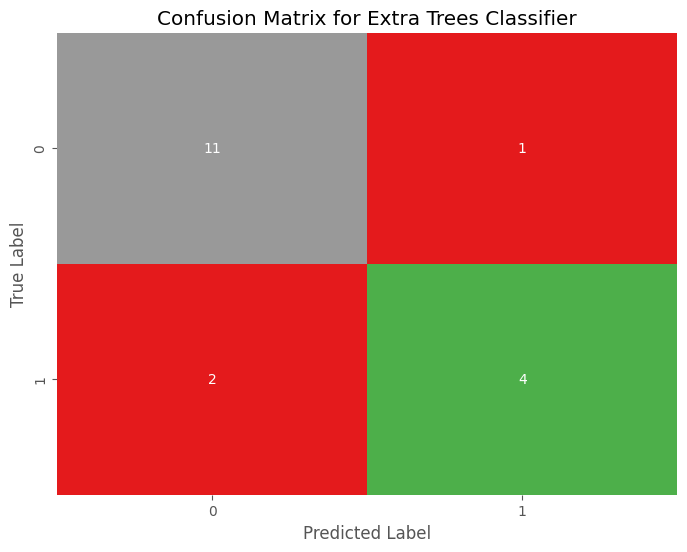

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.80      0.67      0.73         6

    accuracy                           0.83        18
   macro avg       0.82      0.79      0.80        18
weighted avg       0.83      0.83      0.83        18



In [41]:
et_conf_matrix = confusion_matrix(y_test, et_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(et_conf_matrix, annot=True, fmt="d", cmap="Set1", cbar=False)
plt.title('Confusion Matrix for Extra Trees Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print(classification_report(y_test, et_predicted))

Cross Validation

In [43]:
cv_scores_et = cross_val_score(best_et_model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores for Extra Trees Classifier:", cv_scores_et)
print("Mean Cross-validation score for Extra Trees Classifier:", cv_scores_et.mean())
print("Standard Deviation of Cross-validation scores for Extra Trees Classifier:", cv_scores_et.std())

Cross-validation scores for Extra Trees Classifier: [0.8        0.93333333 1.         0.78571429 0.71428571]
Mean Cross-validation score for Extra Trees Classifier: 0.8466666666666667
Standard Deviation of Cross-validation scores for Extra Trees Classifier: 0.10434549276039876


Learning Curve

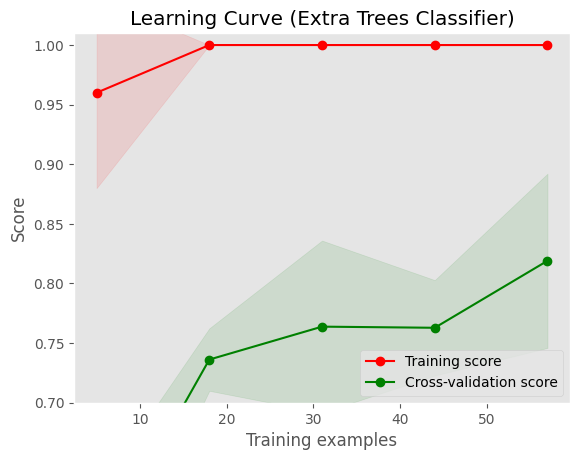

In [44]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(best_et_model, "Learning Curve (Extra Trees Classifier)", X_train, y_train, ylim=(0.7, 1.01), cv=5)

plt.show()